# Parsing Experiment Results

In this notebook, we will be parsing the results of running `experiment.ipynb` from our `results` folder.

In [1]:
# configs
# results_name = 'bench1_sleep_1000_200'
# results_name = 'bench1_sleep_400_200'
results_name = 'bench1_cpu_20k_ps'
results_folder = './results/'
results_logger_glob = f'{results_folder}{results_name}/*_logger.csv'
results_reqs_glob = f'{results_folder}{results_name}/*_reqs.csv'

print(results_logger_glob)
print(results_reqs_glob)

./results/bench1_cpu_20k_ps/*_logger.csv
./results/bench1_cpu_20k_ps/*_reqs.csv


In [2]:
# plotting imports (needs to be before matplotlib)
import pacsltk.pacs_util as pacs_util
pacs_util.prepare_matplotlib_cycler()

# general imports
import os

# parsing imports
from tqdm import tqdm
import pandas as pd
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
# other seaborn aesthetic options: http://seaborn.pydata.org/tutorial/aesthetics.html
sns.set_style("whitegrid")

# for datetime analysis
from datetime import datetime, timedelta
import pytz

my_timezone = os.getenv('PY_TZ', 'America/Toronto')

# for file processing
import glob
import json

# for better printing of variables
from IPython.display import display

In [3]:
# utility functions

In [4]:
# Prepare for plots and make directories
figs_folder = "./figs/"
!mkdir -p {figs_folder}

def get_fig_path(x): return (os.path.join(figs_folder, "exp" +
              x + ".png"), os.path.join(figs_folder, "exp" + x + ".pdf"))

def tmp_fig_save(fig_name):
    paths = get_fig_path(fig_name)
    plt.savefig(paths[0], dpi=300)
    plt.savefig(paths[1])

def parse_epoch_cols(df, epoch_cols_list):
    for epoch_col in epoch_cols_list:
        times = df[epoch_col].apply(lambda x: datetime.fromtimestamp(x).astimezone(pytz.timezone(my_timezone)).replace(tzinfo=None))
        times = pd.to_datetime(times.dt.to_pydatetime())
        df[epoch_col + '_dt'] = times

# Developing Analysis of Logger Data

In [5]:
# get a list of logger files and sort them
logger_file_list = glob.glob(results_logger_glob)
logger_file_list.sort()

# logger_file_list

,ready_count,total_conc,conc_window_average,time,rps,cc,lambda_over_n,current_cc
time_dt,,,,,,,,
2021-01-27 20:56:21.048493,2,3,0.450000,1.611799e+09,1.0,1,0.5,1.5
2021-01-27 20:56:23.053600,2,6,0.375000,1.611799e+09,1.0,1,0.5,3.0
2021-01-27 20:56:25.057563,2,0,0.391667,1.611799e+09,1.0,1,0.5,0.0
2021-01-27 20:56:27.062072,2,0,0.391667,1.611799e+09,1.0,1,0.5,0.0
2021-01-27 20:56:29.064816,2,1,0.358333,1.611799e+09,1.0,1,0.5,0.5


<AxesSubplot:xlabel='time_dt'>

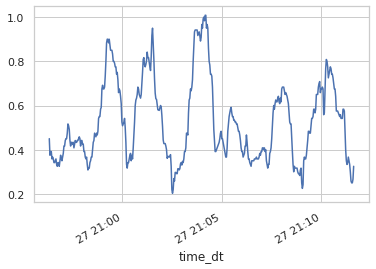

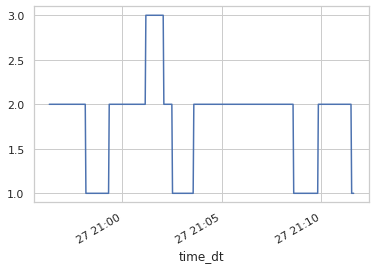

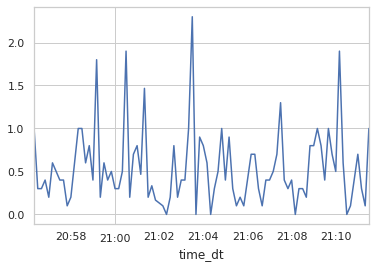

In [6]:
parse_skip_mins = 5

def parse_logger_file(csv_file_path):
    df = pd.read_csv(csv_file_path, index_col=0, parse_dates=True)
    parse_epoch_cols(df, ['time', ])
    # skip 5 minutes
    df = df[df['time_dt'] > df['time_dt'].min() + timedelta(minutes=parse_skip_mins)]
    df['lambda_over_n'] = df['rps'] / df['ready_count']
    df['current_cc'] = df['total_conc'] / df['ready_count']
    # set index to the time
    df = df.set_index('time_dt')
    return df


df = parse_logger_file(logger_file_list[0])
display(df.head())

plt.figure()
df['conc_window_average'].plot()
plt.figure()
df['ready_count'].plot()
plt.figure()
df['current_cc'].resample('10s').mean().plot()

## Analyze Experiment-By-Experiment Results

100%|██████████| 55/55 [00:00<00:00, 57.85it/s]


,conc_window_average_mean,arrival_rate,average_ready_count,cc
0,0.528075,1.0,1.823144,1
1,0.683111,3.0,9.466814,1
2,0.694098,5.0,10.946903,1
3,0.717445,7.0,11.181818,1
4,0.704594,9.0,13.231111,1


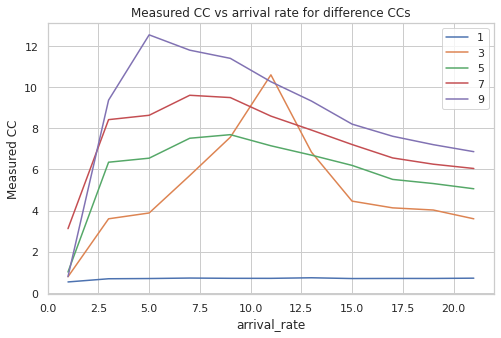

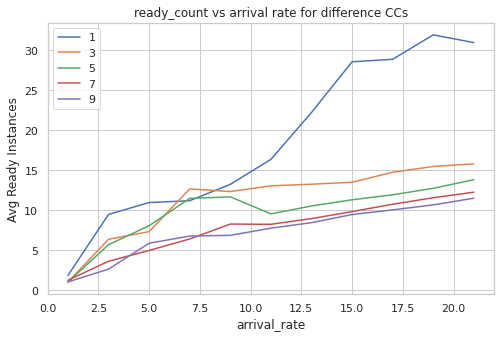

In [7]:
results_arr = []
for file_path in tqdm(logger_file_list):
    df = parse_logger_file(file_path)
    arrival_rate = df['rps'][0]
    cc = df['cc'][0]

    results_arr.append({
        'conc_window_average_mean': df['conc_window_average'].mean(),
        'arrival_rate': arrival_rate,
        'average_ready_count': df['ready_count'].mean(),
        'cc': cc,
    })

df_logger_result = pd.DataFrame(data=results_arr)
display(df_logger_result.head())

plt.figure(figsize=(8,5))
df_logger_result.set_index('arrival_rate').groupby('cc')['conc_window_average_mean'].plot()
plt.title('Measured CC vs arrival rate for difference CCs')
plt.ylabel('Measured CC')
plt.legend()
plt.figure(figsize=(8,5))
df_logger_result.set_index('arrival_rate').groupby('cc')['average_ready_count'].plot()
plt.title('ready_count vs arrival rate for difference CCs')
plt.ylabel('Avg Ready Instances')
plt.legend()

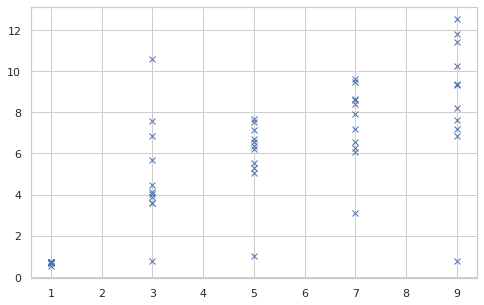

In [8]:
# plotting the set concurrency vs the measured concurrency
plt.figure(figsize=(8,5))
plt.plot(df_logger_result['cc'], df_logger_result['conc_window_average_mean'], 'x')

## Analyze Merged Results

100%|██████████| 55/55 [00:01<00:00, 48.97it/s]


,ready_count,total_conc,conc_window_average,time,rps,cc,current_cc
lambda_over_n,,,,,,,
0.150000,20.000000,11.000000,0.741616,1.611800e+09,3.000000,1.000000,0.550000
0.157895,19.000000,11.750000,0.721677,1.611800e+09,3.000000,1.000000,0.618421
0.166667,22.881356,8.101695,3.585431,1.611807e+09,3.813559,1.813559,0.431638
0.172414,29.000000,14.000000,8.802301,1.611816e+09,5.000000,3.000000,0.482759
0.176471,17.000000,4.515625,4.103221,1.611810e+09,3.000000,2.468750,0.265625


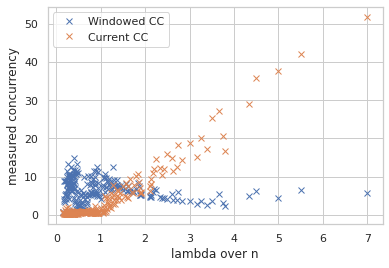

In [9]:
df_logger_merged = pd.DataFrame()
for file_path in tqdm(logger_file_list):
    df = parse_logger_file(file_path)
    df_logger_merged = df_logger_merged.append(df)


df_logger_merged_lon = df_logger_merged.groupby('lambda_over_n').mean()
display(df_logger_merged_lon.head())
# let's analyze the relationship between conc_window_average and lambda_over_n
plt.plot(df_logger_merged_lon.index, df_logger_merged_lon['conc_window_average'], 'x', label='Windowed CC')
plt.plot(df_logger_merged_lon.index, df_logger_merged_lon['current_cc'], 'x', label='Current CC')
plt.xlabel('lambda over n')
plt.ylabel('measured concurrency')
plt.legend()

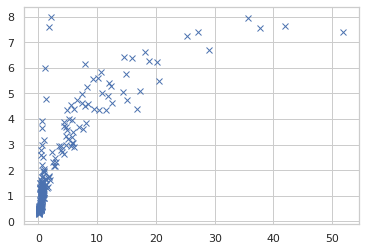

In [10]:
# this tries to model average service time as a function of average number of requests in each container
# plt.plot(df_logger_merged_lon['conc_window_average'], df_logger_merged_lon['conc_window_average'] / df_logger_merged_lon.index, 'x')
plt.plot(df_logger_merged_lon['current_cc'], df_logger_merged_lon['current_cc'] / df_logger_merged_lon.index, 'x')

Now, let's try and see we can see any relationship between $\lambda/N$ and the $\mu$ and $\sigma$ of the measured concurrency.

In [11]:
tmp_res = []
for lambda_over_n in df_logger_merged['lambda_over_n'].unique():
    sub_df = df_logger_merged.loc[df_logger_merged['lambda_over_n'] == lambda_over_n, :]
    if len(sub_df) > 10:
        tmp_res.append({
            'lambda_over_n': lambda_over_n,
            'conc_window_average_mean': np.mean(sub_df['conc_window_average']),
            'conc_window_average_std': np.std(sub_df['conc_window_average']),
            'current_cc_mean': sub_df['current_cc'].mean(),
            'current_cc_std': np.std(sub_df['current_cc']),
        })
    # if len(sub_df) > 400:
    #     plt.figure()
    #     plt.hist(sub_df['conc_window_average'], bins=20)

tmpdf = pd.DataFrame(data=tmp_res)

average std to mean windowed 0.5532158191897829
average std to mean 0.7573415274912229
std to std ratio 1.6841626415557076
7.745966692414834


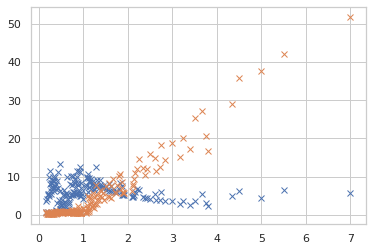

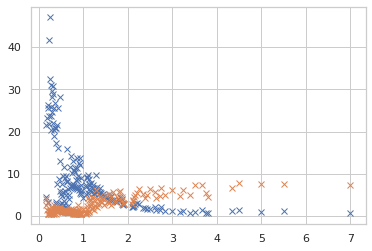

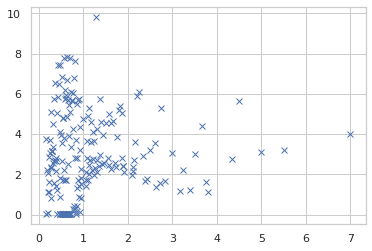

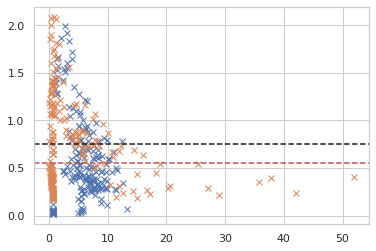

In [12]:
conc_avg_std_to_mean = (tmpdf['conc_window_average_std'] / tmpdf['conc_window_average_mean']).mean()
current_cc_std_to_mean = (tmpdf['current_cc_std'] / tmpdf['current_cc_mean']).mean()
print("average std to mean windowed", conc_avg_std_to_mean)
print("average std to mean", current_cc_std_to_mean)
print("std to std ratio", (tmpdf['current_cc_std'] / tmpdf['conc_window_average_std']).mean())
print(np.sqrt(60))

plt.figure()
plt.plot(tmpdf['lambda_over_n'], tmpdf['conc_window_average_mean'], 'x')
plt.plot(tmpdf['lambda_over_n'], tmpdf['current_cc_mean'], 'x')
plt.figure()
plt.plot(tmpdf['lambda_over_n'], tmpdf['conc_window_average_mean'] / tmpdf['lambda_over_n'], 'x')
plt.plot(tmpdf['lambda_over_n'], tmpdf['current_cc_mean'] / tmpdf['lambda_over_n'], 'x')
plt.figure()
plt.plot(tmpdf['lambda_over_n'], tmpdf['conc_window_average_std'], 'x')
plt.figure()
# plt.plot(tmpdf['lambda_over_n'], tmpdf['conc_window_average_std'] / tmpdf['conc_window_average_mean'], 'x')
# plt.plot(tmpdf['lambda_over_n'], tmpdf['current_cc_std'] / tmpdf['current_cc_mean'], 'x')
plt.plot(tmpdf['conc_window_average_mean'], tmpdf['conc_window_average_std'] / tmpdf['conc_window_average_mean'], 'x')
plt.plot(tmpdf['current_cc_mean'], tmpdf['current_cc_std'] / tmpdf['current_cc_mean'], 'x')
plt.axhline(y=conc_avg_std_to_mean, c='r', ls='--')
plt.axhline(y=current_cc_std_to_mean, c='k', ls='--')

### Try Fitting a Line To Measured Concurrency

In [13]:
x = df_logger_merged_lon.index.values
# y = df_logger_merged_lon['conc_window_average'].values
y = df_logger_merged_lon['current_cc'].values

# reshape for sklearn
x = x.reshape(-1, 1)

[0.0, 1.9937094326439333, 0.9871435234552087]


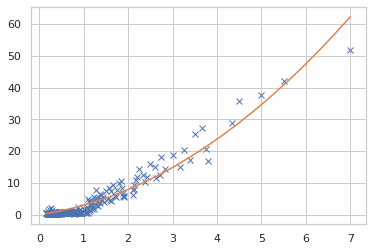

In [14]:
from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error, r2_score

inputProcess = lambda x: np.array([x,x**2]).squeeze().T

plt_x = np.linspace(x.min(), x.max(), 20)
plt_x = plt_x.reshape(-1, 1)


# preprocess input
ix = inputProcess(x)
iplt_x = inputProcess(plt_x)

# Create linear regression object
# regr = linear_model.LinearRegression()
# no intercept might be better because when lambda over n is zero, conc is zero
regr = linear_model.LinearRegression(fit_intercept=False)
# Train the model using the training sets
regr.fit(ix, y)

print([regr.intercept_] + list(regr.coef_))

plt_y = regr.predict(iplt_x)

plt.plot(x,y,'x')
plt.plot(plt_x, plt_y)

In [15]:
# single_point_predict = lambda x: regr.predict(inputProcess(np.array([x]).reshape(-1,1)))[0]

# # xmin = x.min()
# xmin = x.min() + 0.25 * (x.max() - x.min())
# xmax = x.max()

# w1 = single_point_predict(xmin) / xmin
# w2 = single_point_predict(xmax) / xmax

# alpha = (w2 - w1) / (xmax - xmin)
# print(w1, w2, alpha)

In [16]:
# coeffs = [-0.70, 2.08]
# plt_y = plt_x * coeffs[1] + coeffs[0]

# plt.plot(x,y,'x')
# plt.plot(plt_x, plt_y)

# coeffs2 = [0.2247, 0.5306512, 0.46373073]
# plt_y = (plt_x ** 2) * coeffs2[2] + plt_x * coeffs2[1] + coeffs2[0]

# plt.plot(plt_x, plt_y)

# Developing Analysis of Requests Results

In [17]:
reqs_file_list = glob.glob(results_reqs_glob)
reqs_file_list.sort()

,client_start_time,client_end_time,client_elapsed_time,start_conc,end_conc,success,start_ready_count,end_ready_count,rps,cc,client_end_time_dt,lambda_over_n
client_start_time_dt,,,,,,,,,,,,
2021-01-27 20:56:20.599739,1.611799e+09,1.611799e+09,1.192422,4,4,True,2,2,1.0,1,2021-01-27 20:56:21.792161,0.5
2021-01-27 20:56:20.494207,1.611799e+09,1.611799e+09,2.581614,3,6,True,2,2,1.0,1,2021-01-27 20:56:23.075822,0.5
2021-01-27 20:56:20.890525,1.611799e+09,1.611799e+09,2.186447,3,5,True,2,2,1.0,1,2021-01-27 20:56:23.076972,0.5
2021-01-27 20:56:22.680198,1.611799e+09,1.611799e+09,0.574676,5,4,True,2,2,1.0,1,2021-01-27 20:56:23.254873,0.5
2021-01-27 20:56:21.124778,1.611799e+09,1.611799e+09,2.572358,4,3,True,2,2,1.0,1,2021-01-27 20:56:23.697136,0.5


<AxesSubplot:xlabel='client_start_time_dt'>

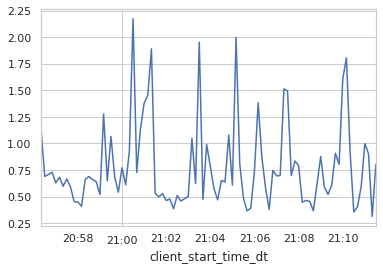

In [18]:
def parse_reqs_file(csv_file_path):
    df = pd.read_csv(csv_file_path, index_col=0, parse_dates=True)
    parse_epoch_cols(df, ['client_start_time', 'client_end_time' ])
    # skip 5 minutes
    df = df[df['client_start_time_dt'] > df['client_start_time_dt'].min() + timedelta(minutes=parse_skip_mins)]
    df['lambda_over_n'] = df['rps'] / df['start_ready_count']
    # # set index to the time
    df = df.set_index('client_start_time_dt')
    return df


df = parse_reqs_file(reqs_file_list[0])
display(df.head())

plt.figure()
df['client_elapsed_time'].resample('10s').mean().plot()

## Analyze Experiment-By-Experiment Results

In [19]:
results_arr = []
for file_path in tqdm(reqs_file_list):
    df = parse_reqs_file(file_path)
    arrival_rate = df['rps'][0]
    cc = df['cc'][0]

    results_arr.append({
        'arrival_rate': arrival_rate,
        'average_resp_time': df['client_elapsed_time'].mean(),
        'average_ready_count': df['start_ready_count'].mean(),
        'lambda_over_n': df['lambda_over_n'].mean(),
        'cc': cc,
    })

df_reqs_result = pd.DataFrame(data=results_arr)
display(df_reqs_result.head())


100%|██████████| 55/55 [00:18<00:00,  2.98it/s]


,arrival_rate,average_resp_time,average_ready_count,lambda_over_n,cc
0,1.0,0.852905,1.840243,0.603134,1
1,3.0,2.031774,9.491280,0.453766,1
2,5.0,1.517577,10.923950,0.475296,1
3,7.0,1.106158,11.199745,0.669154,1
4,9.0,1.035359,13.238840,0.691811,1


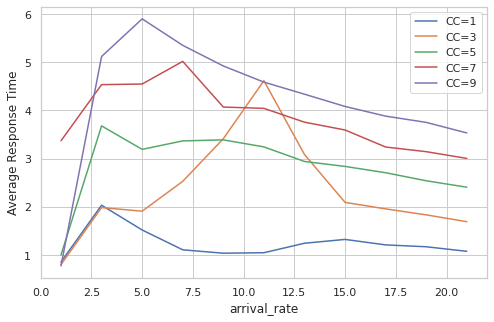

In [20]:
# plt.plot(df_reqs_result['arrival_rate'], df_reqs_result['average_resp_time'])
# relationship between arrival rate and response time
plt.figure(figsize=(8,5))
for cc in df_reqs_result['cc'].unique():
    sub_df = df_reqs_result[df_reqs_result['cc'] == cc]
    tmpdf = sub_df.set_index('arrival_rate')
    tmpdf['average_resp_time'].plot(label=f"CC={cc}")
    
plt.ylabel('Average Response Time')
plt.legend()

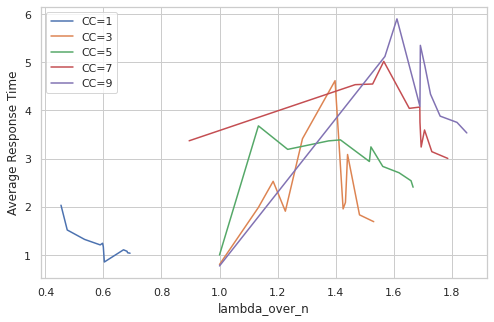

In [21]:
# check for relationships between lambda/N and average response time
plt.figure(figsize=(8,5))
for cc in df_reqs_result['cc'].unique():
    tmpdf = df_reqs_result[df_reqs_result['cc'] == cc]
    tmpdf.groupby('lambda_over_n').mean()['average_resp_time'].plot(label=f"CC={cc}")
    
plt.ylabel('Average Response Time')
plt.legend()

## Analyze Merged Results

In [22]:
df_reqs_merged = pd.DataFrame()
for file_path in tqdm(reqs_file_list):
    df = parse_reqs_file(file_path)
    df_reqs_merged = df_reqs_merged.append(df)


tmpdf = df_reqs_merged.groupby('lambda_over_n').mean()
display(tmpdf.head())

100%|██████████| 55/55 [00:20<00:00,  2.70it/s]


,client_start_time,client_end_time,client_elapsed_time,start_conc,end_conc,success,start_ready_count,end_ready_count,rps,cc
lambda_over_n,,,,,,,,,,
0.150000,1.611800e+09,1.611800e+09,4.478869,11.725000,12.075000,True,20.000000,19.500000,3.000000,1.000000
0.157895,1.611800e+09,1.611800e+09,3.908078,13.149425,12.206897,True,19.000000,19.137931,3.000000,1.000000
0.166667,1.611808e+09,1.611808e+09,2.056229,8.071279,8.046122,True,24.314465,24.218029,4.052411,2.052411
0.172414,1.611816e+09,1.611816e+09,0.341801,18.000000,15.000000,True,29.000000,29.000000,5.000000,3.000000
0.176471,1.611810e+09,1.611810e+09,1.327928,5.494033,5.427208,True,17.000000,17.045346,3.000000,2.465394


cc
1.000000    AxesSubplot(0.125,0.125;0.775x0.755)
1.067340    AxesSubplot(0.125,0.125;0.775x0.755)
1.090062    AxesSubplot(0.125,0.125;0.775x0.755)
1.120950    AxesSubplot(0.125,0.125;0.775x0.755)
1.134810    AxesSubplot(0.125,0.125;0.775x0.755)
                            ...                 
7.142785    AxesSubplot(0.125,0.125;0.775x0.755)
7.321411    AxesSubplot(0.125,0.125;0.775x0.755)
7.323388    AxesSubplot(0.125,0.125;0.775x0.755)
7.867725    AxesSubplot(0.125,0.125;0.775x0.755)
8.059490    AxesSubplot(0.125,0.125;0.775x0.755)
Name: client_elapsed_time, Length: 176, dtype: object

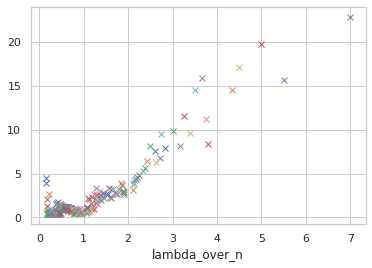

In [23]:
tmpdf.groupby('cc')['client_elapsed_time'].plot(style='x')
# plt.legend()

,lambda_over_n,resp_time_avg
0,0.500000,1.103266
1,1.000000,0.966217
2,0.333333,0.885942
3,0.166667,2.056229
4,0.157895,3.908078


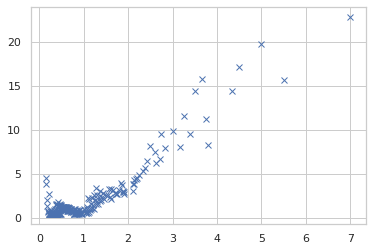

In [24]:
tmp_res = []
for lambda_over_n in df_reqs_merged['lambda_over_n'].unique():
    sub_df = df_reqs_merged.loc[df_reqs_merged['lambda_over_n'] == lambda_over_n, :]
    if len(sub_df) > 10:
        tmp_res.append({
            'lambda_over_n': lambda_over_n,
            'resp_time_avg': np.mean(sub_df['client_elapsed_time']),
        })

tmpdf = pd.DataFrame(data=tmp_res)
display(tmpdf.head())

plt.plot(tmpdf['lambda_over_n'], tmpdf['resp_time_avg'], 'x')

In [25]:
x = tmpdf['lambda_over_n']
y = tmpdf['resp_time_avg']

[-0.1269532405789393, 1.5703963300595092, 0.33667310609164847]


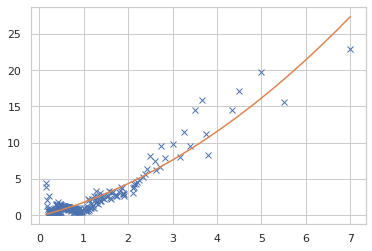

In [26]:
inputProcess = lambda x: np.array([x,x**2]).squeeze().T

plt_x = np.linspace(x.min(), x.max(), 20)
plt_x = plt_x.reshape(-1, 1)


# preprocess input
ix = inputProcess(x)
iplt_x = inputProcess(plt_x)

# Create linear regression object
# regr = linear_model.LinearRegression()
# no intercept might be better because when lambda over n is zero, conc is zero
regr = linear_model.LinearRegression(fit_intercept=True)
# Train the model using the training sets
regr.fit(ix, y)

print([regr.intercept_] + list(regr.coef_))

plt_y = regr.predict(iplt_x)

plt.plot(x,y,'x')
plt.plot(plt_x, plt_y)

# Plots for Analyzing Effect of Concurrency

,conc_window_average_mean,arrival_rate,average_ready_count,cc
5,0.703233,11.0,16.359202,1
16,10.600334,11.0,13.046667,3
27,7.150509,11.0,9.529801,5
38,8.593397,11.0,8.222467,7
49,10.265194,11.0,7.737778,9


,arrival_rate,average_resp_time,average_ready_count,lambda_over_n,cc
5,11.0,1.045395,16.335927,0.683123,1
16,11.0,4.616821,14.032887,1.398252,3
27,11.0,3.242462,9.711609,1.521781,5
38,11.0,4.042371,8.528419,1.653940,7
49,11.0,4.587142,8.099788,1.668853,9


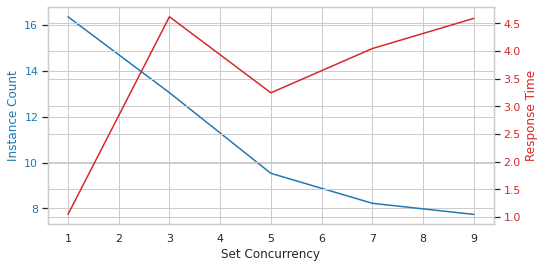

In [27]:
# let's see if we can make plots for effect of CC
plot_arrival_rate = 11

sub_df1 = df_logger_result[df_logger_result['arrival_rate'] == plot_arrival_rate]
sub_df2 = df_reqs_result[df_reqs_result['arrival_rate'] == plot_arrival_rate]
display(sub_df1.head())
display(sub_df2.head())

plt.figure(figsize=(8,4))
color = 'tab:blue'
ax1 = plt.gca()
ax1.plot(sub_df1['cc'], sub_df1['average_ready_count'], color=color)
ax1.set_xlabel('Set Concurrency')
ax1.set_ylabel('Instance Count', color=color)
ax1.tick_params(axis='y', labelcolor=color)

color = 'tab:red'
ax2 = plt.gca().twinx()
ax2.plot(sub_df2['cc'], sub_df2['average_resp_time'], color)
ax2.set_ylabel('Response Time', color=color)
ax2.tick_params(axis='y', labelcolor=color)